# Extract coastal waterlines across time
**What does this notebook do?** 

This notebooks demonstrates how to tidally tag remotely sensed imagery using the [OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html) model, create geomedian composites for a given set of epochs and tidal range, and extract waterline contours from the composite layers for each epoch. 

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea/20180515`  *(currently using an older version of `dea` due to a bug in `xr.concat`; will be reverted to `module load dea` in future)*

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** September 2018

**Author:** Robbi Bishop-Taylor

## Import modules

In [21]:
import os
import sys
import datacube
import itertools
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube_stats.statistics import GeoMedian
from dateutil.relativedelta import relativedelta
from datacube.helpers import ga_pq_fuser
from datacube.helpers import write_geotiff
from datacube.storage import masking
from shapely.geometry import Point
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# For nicer notebook plotting, hide warnings (comment out for real analysis)
warnings.filterwarnings('ignore') 

# Create datacube instance
# dc = datacube.Datacube(app='Tidal geomedian filmstrips')
from datacube.model import Range
dc = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')



def date_range(start_date, end_date, increment, period):
    
    """Generate dates seperated by given time increment/period"""
    
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

def ds_to_rgb(ds, bands=['red', 'green', 'blue'], reflect_stand=4000):
    
    """Converts an xarray dataset to a three band array"""
    
    rawimg = np.transpose(ds[bands].to_array().data, [1, 2, 0])
    img_toshow = (rawimg / reflect_stand).clip(0, 1)
    return img_toshow


## Geomedian filmstrip parameters
Set the area, time period  and sensors of interest, and tide limits and epoch length used to produce each geomedian composite. This is the only cell that needs to be edited to run the notebook.

In [74]:
# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'pointstuart_wide'  # name used as prefix for output files
# lat, lon = -12.238, 131.849  # centre of study area
# buffer = 15000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'mitchell'  # name used as prefix for output files
# lat, lon = -15.14995, 141.63650  # centre of study area
# buffer = 10000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'inskip'  # name used as prefix for output files
# lat, lon = -25.7909598625, 153.073231901  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# Set up centre of study area and buffer size in metres for data extraction
study_area = 'narrabeen_utm'  # name used as prefix for output files
lat, lon = -33.72, 151.3006  # centre of study area
buffer = 2000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'victoriariver_2yr'  # name used as prefix for output files
# lat, lon = -15.4440342949, 129.811912341  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'victoriariver2_2yr'  # name used as prefix for output files
# lat, lon = -15.4475061785, 130.128534164  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'ard_test_comp'  # name used as prefix for output files
# lat, lon = -19.4889944734, 147.507306961  # centre of study area
# buffer = 10800  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'kingashbaylarge'  # name used as prefix for output files
# lat, lon = -15.913720, 136.494590  # centre of study area
# buffer = 10000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'oldbar'  # name used as prefix for output files
# lat, lon = -31.965, 152.593  # centre of study area
# buffer = 2000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'seals'  # name used as prefix for output files
# lat, lon = -32.443603, 152.527712  # centre of study area
# buffer = 2000  # metre units to extend region of interest on each side of centre point

# Set up compositing parameters
time_period = ('1987-01-01', '2018-12-29')  # Total date range to import data from
sensors = ['ls5', 'ls7', 'ls8']  # Landsat sensors from which to import data from
ls7_slc_off = False # Whether to include striped > May 31 2003 Landsat 7 SLC-off data
lower_tideheight = 0.0 # Minimum proportion of the observed tidal range to include 
upper_tideheight = 1.0  # Maximum proportion of the observed tidal range to include 
epoch_years = 1  # Length of each epoch used to compute geomedians (i.e. 5 years = 1988 to 1993)

# Set up query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),
         'time': time_period,
         'crs': 'EPSG:3577'}

DEAPlotting.display_map(x=query['x'], y=query['y'])

## Return observations for each sensor for the entire time series
Use `dask` to lazily load Landsat data and PQ for each sensor for the entire time series. No data is actually loaded here: this is saved until after the layers have been filtered by tidal stage and date to save processing time.

In [75]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))
    
if not os.path.isdir('figures/{}/'.format(study_area)):
    os.makedirs('figures/{}/'.format(study_area))

# Create list of epochs between start and end of time_period in datetime format
start = datetime.strptime(time_period[0], '%Y-%m-%d')
end = datetime.strptime(time_period[1], '%Y-%m-%d')
epochs = date_range(start, end, epoch_years, 'years')

# Print list of epochs
epochs_strings = [epoch.strftime('%Y-%m-%d') for epoch in epochs][:-1]
print('Processing {} epochs: {}'.format(len(epochs_strings), ', '.join(epochs_strings)))

# # Identify tide point by importing ITEM polygons
# polygons_gpd = gpd.read_file('/g/data/r78/intertidal/GA_native_tidal_model.shp')
# polygon_gpd = polygons_gpd[polygons_gpd.intersects(Point(lon, lat))]
# tidepost_lon, tidepost_lat = polygon_gpd[['lon', 'lat']].values[0]
tidepost_lat, tidepost_lon  = lat, lon
print('Using tidepost coordinates: {} E, {} S\n'.format(tidepost_lon, tidepost_lat))

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# For each sensor, dask load data and compute tide heights for each sensor
for sensor in sensors:
    
    # The following code will fail if there is no data for the sensor in time_period;
    # this try statement catches this and skips the affected sensor    
    try:
    
        # Return observations matching query without actually loading them using dask
        sensor_all = dc.load(product = '{}_ard'.format(sensor), 
                             group_by = 'solar_day', 
                             output_crs = 'EPSG:32756',
                             measurements = ['nbart_red', 'nbart_blue', 'nbart_green', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                             resolution = (-30, 30),
                             dask_chunks={'time': 1},
                             **query)

        
        # Remove Landsat 7 SLC-off from PQ layer if ls7_slc_off = False
        if not ls7_slc_off and sensor == 'ls7':
            sensor_all = sensor_all.where(sensor_all.time < np.datetime64('2003-05-30'), drop=True) 

        # Use the tidal mode to compute tide heights for each observation:
        print('Computing tidal heights for {} {} observations'.format(len(sensor_all.time), sensor))
        obs_datetimes = sensor_all.time.data.astype('M8[s]').astype('O').tolist()
        obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
        obs_predictedtides = predict_tide(obs_timepoints)
        obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

        # Assign tide heights to the dataset as a new variable
        sensor_all['tide_heights'] = xr.DataArray(obs_tideheights, [('time', sensor_all.time)]) 

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_all = sensor_all.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                        'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
        sensor_dict[sensor] = sensor_all
    
    except AttributeError:
        
        print('{} selection failed due to likely lack of data in time_period; skipping'.format(sensor))

Processing 31 epochs: 1987-01-01, 1988-01-01, 1989-01-01, 1990-01-01, 1991-01-01, 1992-01-01, 1993-01-01, 1994-01-01, 1995-01-01, 1996-01-01, 1997-01-01, 1998-01-01, 1999-01-01, 2000-01-01, 2001-01-01, 2002-01-01, 2003-01-01, 2004-01-01, 2005-01-01, 2006-01-01, 2007-01-01, 2008-01-01, 2009-01-01, 2010-01-01, 2011-01-01, 2012-01-01, 2013-01-01, 2014-01-01, 2015-01-01, 2016-01-01, 2017-01-01
Using tidepost coordinates: 151.3006 E, -33.72 S

Computing tidal heights for 399 ls5 observations
Computing tidal heights for 86 ls7 observations
Computing tidal heights for 125 ls8 observations


## Subset data by tidal height and epoch time range
Use image time-stamps to compute tidal heights at the time of each observation, and take a subset of the entire Landsat and PQ time series based on tide height and epoch date range for each sensor.

In [76]:
# If any sensor has 0 observations, remove it from the dictionary before proceeding
sensor_dict = {key:value for key, value in sensor_dict.items() if len(value.time) > 0}

# Calculate max and min tide heights for the entire time series and all sensors
obs_min = np.min([sensor_ds.tide_heights.min() for sensor_ds in sensor_dict.values()])
obs_max = np.max([sensor_ds.tide_heights.max() for sensor_ds in sensor_dict.values()])
obs_range = obs_max - obs_min

# Calculate tidal limits used for subsequent data selection
sel_min = obs_min + (obs_range * lower_tideheight)
sel_max = obs_min + (obs_range * upper_tideheight)
print('Keeping tidal heights of {0:.2f} m to {1:.2f} m out of an observed local tidal ' 
      'range of {2:.2f} m to {3:.2f} m'.format(sel_min, sel_max, obs_min, obs_max))

# Create dictionaries to hold filtered sensor data for each epoch
sensor_epoch_dict = defaultdict(list)
pq_epoch_dict = defaultdict(list)
   
for epoch, sensor in itertools.product(epochs[:-1], sensor_dict.keys()):
                                           
    # Select dataset
    sensor_subset = sensor_dict[sensor]  
    
    # Filter by tidal stage
    sensor_subset = sensor_subset.where((sensor_subset.tide_heights >= sel_min) &
                                        (sensor_subset.tide_heights <= sel_max), drop = True)
    

    # Identify from and to date strings
    from_date = epoch.strftime('%Y-%m-%d')
    to_date = (epoch + relativedelta(years=epoch_years)).strftime('%Y-%m-%d')
    
    # Subset sensor to from and to date for epoch
    print('    Filtering from {} to {} for {}'.format(from_date, to_date, sensor))
    sensor_subset = sensor_subset.sel(time=slice(from_date, to_date))

    # Add subsetted data to dicts (one key matching a list of sensor data for each epoch)
    sensor_epoch_dict[from_date].append(sensor_subset)
    

Keeping tidal heights of -0.62 m to 1.07 m out of an observed local tidal range of -0.62 m to 1.07 m
    Filtering from 1987-01-01 to 1988-01-01 for ls5
    Filtering from 1987-01-01 to 1988-01-01 for ls7
    Filtering from 1987-01-01 to 1988-01-01 for ls8
    Filtering from 1988-01-01 to 1989-01-01 for ls5
    Filtering from 1988-01-01 to 1989-01-01 for ls7
    Filtering from 1988-01-01 to 1989-01-01 for ls8
    Filtering from 1989-01-01 to 1990-01-01 for ls5
    Filtering from 1989-01-01 to 1990-01-01 for ls7
    Filtering from 1989-01-01 to 1990-01-01 for ls8
    Filtering from 1990-01-01 to 1991-01-01 for ls5
    Filtering from 1990-01-01 to 1991-01-01 for ls7
    Filtering from 1990-01-01 to 1991-01-01 for ls8
    Filtering from 1991-01-01 to 1992-01-01 for ls5
    Filtering from 1991-01-01 to 1992-01-01 for ls7
    Filtering from 1991-01-01 to 1992-01-01 for ls8
    Filtering from 1992-01-01 to 1993-01-01 for ls5
    Filtering from 1992-01-01 to 1993-01-01 for ls7
    Filtering f

## Combine multiple sensors, load data and generate geomedians
For each epoch, combine all sensors into one dataset, load the data for the first time using `dask`'s `.compute()`, then composite all timesteps into a single array using a geometric median computation.

In [77]:
# Dict to hold output geomedian composites
ndwi_dict = {}
mndwi_dict = {}
awei_ns_dict = {}
awei_s_dict = {}
tideheights_dict = {}

for from_date in sensor_epoch_dict.keys():
    
    # For the first time, actually load data for all sensors and then combine into one dataset  
    print('Loading and combining {} data for {}'.format(", ".join(sensor_dict.keys()), from_date))
    sensor_combined = xr.concat([i.compute() for i in sensor_epoch_dict[from_date]], dim='time')
    
    # Sort output datasets by date
    sensor_combined = sensor_combined.sortby('time')
    
    # Identify pixels with valid data
    good_quality = np.isin(sensor_combined['fmask'], test_elements=(0, 2, 3), invert=True)
    good_quality = sensor_combined['fmask'].where(good_quality).notnull()
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    print('    Applying PQ mask and setting nodata to NaN')
    sensor_combined = sensor_combined.where(good_quality)
    sensor_combined = masking.mask_invalid_data(sensor_combined)
    
    # Compute NDWI
    sensor_combined["ndwi"] = (sensor_combined.green - sensor_combined.nir) / (sensor_combined.green + sensor_combined.nir)
    sensor_combined["mndwi"] = (sensor_combined.green - sensor_combined.swir1) / (sensor_combined.green + sensor_combined.swir1)
    sensor_combined["awei_ns"] = (4 * (sensor_combined.green * 0.0001 - sensor_combined.swir1 * 0.0001) -
                              (0.25 * sensor_combined.nir * 0.0001 + 2.75 * sensor_combined.swir2 * 0.0001))
    sensor_combined["awei_s"] = (sensor_combined.blue * 0.0001 + 2.5 * sensor_combined.green * 0.0001 - 
                                 1.5 * (sensor_combined.nir * 0.0001 + sensor_combined.swir1 * 0.0001) - 0.25 * sensor_combined.swir2 * 0.0001)

    # Compute NDWI composite using all timesteps
    print('    Computing NDWI, MNDWI and AWEI median')
    ndwi_median = sensor_combined[["ndwi"]].median(dim='time', keep_attrs=True)
    mndwi_median = sensor_combined[["mndwi"]].median(dim='time', keep_attrs=True)
    awei_ns_median = sensor_combined[["awei_ns"]].median(dim='time', keep_attrs=True)
    awei_s_median = sensor_combined[["awei_s"]].median(dim='time', keep_attrs=True)
    
    # Export to file
    print('    Exporting to file')
    filename_ndwi = 'output_data/{0}/{0}_{1}_ndwi.tif'.format(study_area, from_date)
    filename_mndwi = 'output_data/{0}/{0}_{1}_mndwi.tif'.format(study_area, from_date)
    filename_awei_ns = 'output_data/{0}/{0}_{1}_awei_ns.tif'.format(study_area, from_date)
    filename_awei_s = 'output_data/{0}/{0}_{1}_awei_s.tif'.format(study_area, from_date)
    write_geotiff(filename=filename_ndwi, dataset=ndwi_median)
    write_geotiff(filename=filename_mndwi, dataset=mndwi_median)
    write_geotiff(filename=filename_awei_ns, dataset=awei_ns_median)
    write_geotiff(filename=filename_awei_s, dataset=awei_s_median)
    
    # Assign to dict
    ndwi_dict[from_date] = ndwi_median
    mndwi_dict[from_date] = mndwi_median
    awei_ns_dict[from_date] = awei_ns_median
    awei_s_dict[from_date] = awei_s_median
    

Loading and combining ls5, ls7, ls8 data for 1987-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1988-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1989-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1990-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1991-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1992-01-01
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to fil

## Extract waterlines

In [156]:
threshold = 0.17
metric = 'ndwi'

from skimage import filters

for date, data in ndwi_dict.items():
    
    print(date)
    
    # Prepare attributes as input to contour extract
    attribute_data = {'date': [date[0:4]]}
    attribute_dtypes = {'date': 'int'}
    
    try:

#         threshold = filters.threshold_otsu(data[metric].values)

        # Extract contours with custom attribute fields:
        contour_dict = SpatialTools.contour_extract(z_values=[threshold],
                                       ds_array=data[metric],
                                       ds_crs='epsg:32756',
                                       ds_affine=data.geobox.transform,
                                       output_shp=f'output_data/{study_area}/{study_area}_{metric}_{date}.shp',
                                       attribute_data=attribute_data,
                                       attribute_dtypes=attribute_dtypes)
    except:
        print('none')
    
# Combine all shapefiles into one file
import glob
shapefiles = glob.glob(f'output_data/{study_area}/{study_area}_{metric}_*01-01.shp')
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# Save as combined shapefile
gdf = gdf.reset_index()[['date', 'geometry']].sort_values('date')
gdf['date'] = gdf['date'].astype(np.float32)
gdf.crs = 'epsg:32756'
gdf.to_file(f'output_data/{study_area}/{study_area}_{metric}_combined.shp')

gdf['date'].dtype
gdf

1987-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting contour shapefile to output_data/narrabeen_utm/narrabeen_utm_ndwi_1987-01-01.shp
1988-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting contour shapefile to output_data/narrabeen_utm/narrabeen_utm_ndwi_1988-01-01.shp
1989-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting contour shapefile to output_data/narrabeen_utm/narrabeen_utm_ndwi_1989-01-01.shp
1990-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting contour shapefile to output_data/narrabeen_utm/narrabeen_utm_ndwi_1990-01-01.shp
1991-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting contour shapefile to output_data/narrabeen_utm/narrabeen_utm_ndwi_1991-01-01.shp
1992-01-01
Operating in single array, multiple z-values mode
    Extracting contour 0.17
Exporting c

,date,geometry
28,1987.0,"(LINESTRING (344012.6940102418 6265305, 343995..."
14,1988.0,"(LINESTRING (343994.8634153328 6265305, 343965..."
8,1989.0,"(LINESTRING (343973.930091489 6265305, 343965 ..."
0,1990.0,"(LINESTRING (343985.9703526042 6265305, 343965..."
3,1991.0,"(LINESTRING (344865 6265744.075321543, 344854...."
10,1992.0,"(LINESTRING (343561.2755031306 6269895, 343571..."
6,1993.0,"(LINESTRING (343991.6292726087 6265305, 343965..."
18,1994.0,"(LINESTRING (343993.3078976407 6265305, 343965..."
17,1995.0,"(LINESTRING (343998.3335054348 6265305, 343995..."
2,1996.0,"(LINESTRING (343977.2178675449 6265305, 343965..."


## Validation against Narrabeen beach width data

In [154]:
import re
from pyproj import Proj, transform
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import numpy as np

def dms2dd(s):
    # example: s = "0°51'56.29"
    degrees, minutes, seconds = re.split('[°\'"]+', s)
    if float(degrees) > 0:
        dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    else:
        dd = float(degrees) - float(minutes)/60 - float(seconds)/(60*60);
    return dd

def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})


# Import data and parse DMS to DD
data = "PF1 -33°42'20.65 151°18'16.30 118.42\nPF2 -33°42'33.45 151°18'10.33 113.36\nPF4 -33°43'01.55 151°17'58.84 100.26\nPF6 -33°43'29.81 151°17'58.65 83.65\nPF8 -33°43'55.94 151°18'06.47 60.48"
coords = pd.read_csv(pd.compat.StringIO(data), sep=' ', names=['site', 'y', 'x', 'angle'])
coords['x'] = [dms2dd(i) for i in coords.x]
coords['y'] = [dms2dd(i) for i in coords.y]

# Extend survey lines out from start coordinates using supplied angle
coords_end = coords.apply(lambda x: dist_angle(x.x, x.y, 0.005, x.angle), axis = 1)
coords = pd.concat([coords, coords_end], axis=1).drop('angle', axis=1)

# Reproject coords to Albers and create geodataframe
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:32756')
coords['x'], coords['y'] = transform(inProj,outProj,coords.x.values,coords.y.values)
coords['x2'], coords['y2'] = transform(inProj,outProj,coords.x2.values,coords.y2.values)
coords['geometry'] = coords.apply(lambda x: LineString([Point(x.x, x.y), Point(x.x2, x.y2)]), axis = 1)
transects_gdf = gpd.GeoDataFrame(coords, geometry='geometry').set_index('site')
transects_gdf.crs = 'EPSG:32756'

# Export to file
transects_gdf.reset_index().to_file('narrabeen_transects.shp')


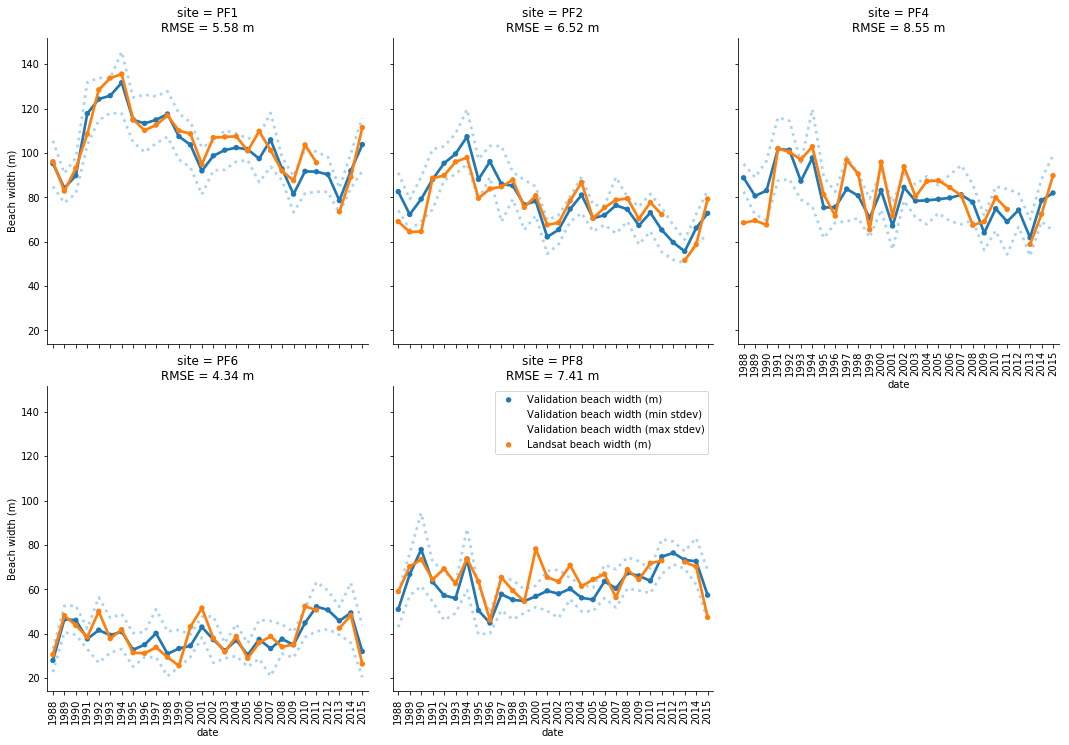

In [157]:
out_list = []

for transect_id in ['PF1', 'PF2', 'PF4', 'PF6', 'PF8']:

    ###########
    # Landsat #
    ###########

    # Import contours
    contours_gpf = gpd.read_file('output_data/narrabeen_utm/narrabeen_utm_ndwi_combined.shp').set_index('date')
    contours_gdf = contours_gpf.drop([1987.0, 2016.0, 2017.0])

    # Extract intersections for transect 
    intersect_gdf = gpd.GeoDataFrame(geometry = contours_gdf.intersection(transects_gdf.loc[transect_id].geometry))
    intersect_gdf.crs = 'EPSG:32756'
#     intersect_gdf.reset_index().to_file('intersect_transect1.shp')

    # Compute distances
    landsat_beachwidths = intersect_gdf.distance(Point(transects_gdf.loc[transect_id].geometry.coords[0]))
    landsat_beachwidths = landsat_beachwidths.rename('Landsat beach width (m)')


    ##############
    # Validation #
    ##############

    profiles_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/Narrabeen/Narrabeen_Profiles.csv', 
                              skiprows=1, names=['site', 'date', 'distance', 'elevation', 'flag'])

    # Set to datetime
    profiles_df['date'] = pd.to_datetime(profiles_df['date'], format='%d/%m/%Y')

    # Restrict to years
    profiles_df = profiles_df[(profiles_df.date.dt.year > 1987) & (profiles_df.date.dt.year < 2016)]

    # Use linear interpolation to find distance along beach of 0 elevation 
    from scipy.interpolate import interp1d
    profiles_interp = profiles_df.groupby(['site', 'date']).apply(lambda x: interp1d(x.elevation, x.distance)(0) if 
                                                                    x.elevation.min() < 0 else np.nan)  #.plot()

    profiles_interp = profiles_interp.loc[transect_id].astype(np.float)
    validation_beachwidths = profiles_interp.groupby(profiles_interp.index.year).mean()
    validation_beachwidths_std = profiles_interp.groupby(profiles_interp.index.year).std()
    validation_beachwidths = validation_beachwidths.rename('Validation beach width (m)')
    validation_beachwidths_std = validation_beachwidths_std.rename('Validation beach width (stdev)')

    # Combine into a single dataframe and append to output list
    landsat_validation_df = pd.DataFrame([validation_beachwidths, validation_beachwidths_std, landsat_beachwidths]).T
    landsat_validation_df['site'] = transect_id
    landsat_validation_df['RMSE'] = ((landsat_validation_df['Validation beach width (m)'] - landsat_validation_df['Landsat beach width (m)']) ** 2).mean() ** .5
    out_list.append(landsat_validation_df)
    
# Plot
import seaborn as sns 
combined_df_wide = pd.concat(out_list).reset_index()
combined_df_wide['Validation beach width (min stdev)'] = combined_df_wide['Validation beach width (m)'] - combined_df_wide['Validation beach width (stdev)']
combined_df_wide['Validation beach width (max stdev)'] = combined_df_wide['Validation beach width (m)'] + combined_df_wide['Validation beach width (stdev)']
combined_df_wide =  combined_df_wide.drop(['Validation beach width (stdev)'], axis=1)
combined_df_wide = combined_df_wide.iloc[:, [0, 1, 5, 6, 2, 3, 4]]

combined_df = pd.melt(combined_df_wide, id_vars=['site', 'date', 'RMSE'], value_name='Beach width (m)')
g = sns.catplot(data=combined_df, x='date', y='Beach width (m)', hue='variable', col='site', kind='point', legend=False, col_wrap=3, 
                palette=['#1f77b4', '#a8d2f0', '#a8d2f0', '#ff7f0e'], markers=[".", "", "", "."], linestyles=['-', ':', ':', '-'])
g.set_xticklabels(rotation=90)

axes = g.axes.flatten()
for i, ax in enumerate(axes):
    current_title = ax.get_title()
    current_rmse = np.round(combined_df.groupby('site').RMSE.max()[i], 2)
    ax.set_title(f'{current_title}\nRMSE = {np.round(current_rmse, 2)} m')
plt.legend(loc='upper right')

    

8.107994662611711
LinregressResult(slope=1.0581323097801114, intercept=-1.003151907085197, rvalue=0.9589824582678003, pvalue=1.9685415981554e-77, stderr=0.026625014760133632)


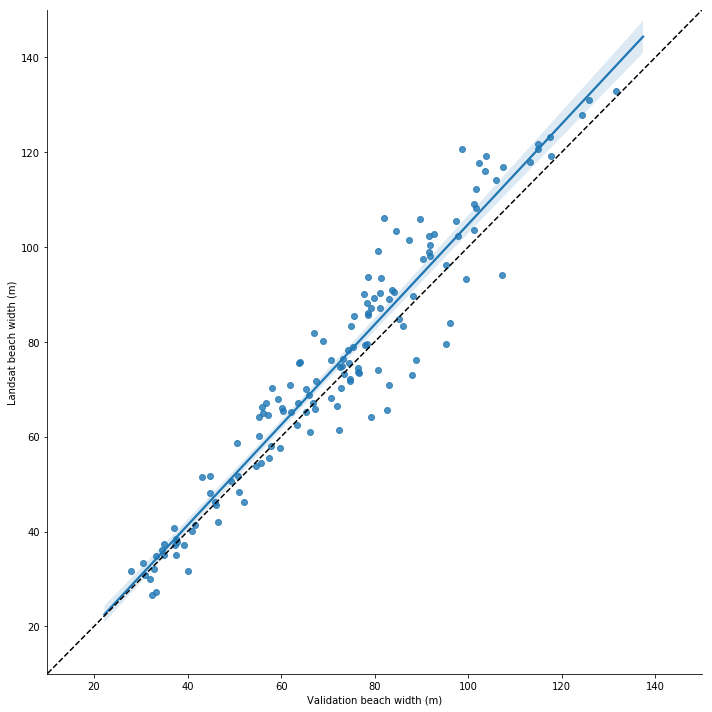

In [837]:
sns.lmplot(data=combined_df_wide, x='Validation beach width (m)', y='Landsat beach width (m)', height=10, aspect=1.0)
plt.plot(np.linspace(0, 150), np.linspace(0, 150), 'black', linestyle='dashed')
plt.ylim([10,150])
plt.xlim([10,150])

print(((combined_df_wide['Validation beach width (m)'] - combined_df_wide['Landsat beach width (m)']) ** 2).mean() ** .5)
import scipy.stats
print(scipy.stats.linregress(combined_df_wide['Validation beach width (m)'], combined_df_wide['Landsat beach width (m)']))

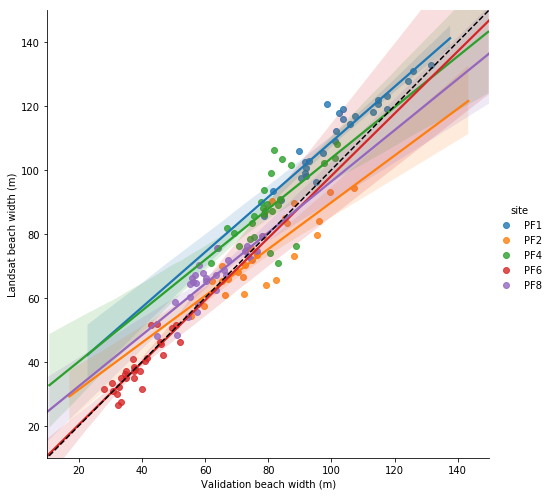

In [838]:
sns.lmplot(data=combined_df_wide, x='Validation beach width (m)', y='Landsat beach width (m)',hue='site', height=7, aspect=1.0)
plt.plot(np.linspace(0, 150), np.linspace(0, 150), 'black', linestyle='dashed')
plt.ylim([10,150]); plt.xlim([10,150]);


## Validation against NSW profile data

In [21]:
profile_data = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/nsw_transects/photogrammetry_Xsections_Lighthouse Beach.csv', skiprows=5)
profile_data.head()

,Beach,Block,Profile,Year/Date,Chainage,Elevation,Easting,Northing,Survey Type
0,Lighthouse Beach,1,1,1963-12-21,0.000,38.479,454727.87,6410056.30,Stereo photogrammtery
1,Lighthouse Beach,1,1,1963-12-21,33.895,35.263,454742.57,6410025.76,Stereo photogrammtery
2,Lighthouse Beach,1,1,1963-12-21,69.047,33.937,454757.83,6409994.09,Stereo photogrammtery
3,Lighthouse Beach,1,1,1963-12-21,80.375,34.499,454762.74,6409983.88,Stereo photogrammtery
4,Lighthouse Beach,1,1,1963-12-21,105.171,33.816,454773.51,6409961.55,Stereo photogrammtery


In [48]:
# profiles_subzero = profile_data.groupby(['Block', 'Profile', 'Year/Date']).filter(lambda x: x['Elevation'].min() <= 0)
# profiles_subzero

In [64]:
from scipy.interpolate import interp1d
shoreline_dist = profile_data.groupby(['Block', 'Profile', 'Year/Date']).apply(lambda x: interp1d(x.Elevation, x.Chainage)(0) if 
                                                                    x.Elevation.min() < 0 else np.nan).dropna()  #.plot()

shoreline_dist.name = 'dist_waterline'
shoreline_dist = profile_data.groupby(['Block', 'Profile', 'Year/Date']).first().join(shoreline_dist).dropna()
shoreline_dist.head()

Beach  Chainage  Elevation    Easting  \
Block Profile Year/Date                                                      
1     2       2016-08-02  Lighthouse Beach       0.0     34.507  454772.92   
      3       2016-08-02  Lighthouse Beach       0.0     22.888  454817.96   
      4       2016-08-02  Lighthouse Beach       0.0     19.621  454863.01   
      7       2016-08-02  Lighthouse Beach       0.0     16.727  454998.14   
      8       2016-08-02  Lighthouse Beach       0.0     16.708  455043.19   

                            Northing Survey Type      dist_waterline  
Block Profile Year/Date                                               
1     2       2016-08-02  6410078.00       LiDar  230.85238636363636  
      3       2016-08-02  6410099.71       LiDar  221.73049999999998  
      4       2016-08-02  6410121.41       LiDar  215.45223076923077  
      7       2016-08-02  6410186.51       LiDar  202.89049999999997  
      8       2016-08-02  6410208.22       LiDar            199.5468

In [43]:
# 154 degrees
def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})

dist_angle(454727.87, 6410056.30, 250, 154)

y2    6.409832e+06
x2    4.548375e+05
dtype: float64

In [84]:
import re
from pyproj import Proj, transform
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import numpy as np


coords_end = shoreline_dist.apply(lambda x: dist_angle(x.Easting, x.Northing, x.dist_waterline, 154), axis = 1)
coords = pd.concat([shoreline_dist, coords_end], axis=1)  #.drop('angle', axis=1)
coords



# Reproject coords to Albers and create geodataframe
inProj = Proj(init='epsg:28356')
outProj = Proj(init='epsg:3577')
coords['x'], coords['y'] = transform(inProj,outProj,coords.Easting.values,coords.Northing.values)
coords['x2'], coords['y2'] = transform(inProj,outProj,coords.x2.values,coords.y2.values)
coords['geometry'] = coords.apply(lambda x: LineString([Point(x.x, x.y), Point(x.x2, x.y2)]), axis = 1)
transects_gdf = gpd.GeoDataFrame(coords, geometry='geometry').set_index('Beach')
transects_gdf.crs = 'EPSG:3577'
transects_gdf = transects_gdf[['geometry']]
# transects_gdf.plot()

# Export to file
transects_gdf.reset_index().to_file('lighthouse_transects.shp')

Beach  Chainage  Elevation    Easting  \
Block Profile Year/Date                                                      
1     2       2016-08-02  Lighthouse Beach       0.0     34.507  454772.92   
      3       2016-08-02  Lighthouse Beach       0.0     22.888  454817.96   
      4       2016-08-02  Lighthouse Beach       0.0     19.621  454863.01   
      7       2016-08-02  Lighthouse Beach       0.0     16.727  454998.14   
      8       2016-08-02  Lighthouse Beach       0.0     16.708  455043.19   
      9       2016-08-02  Lighthouse Beach       0.0     18.883  455088.23   
      11      2016-08-02  Lighthouse Beach       0.0     14.789  455178.32   
      13      2016-08-02  Lighthouse Beach       0.0     22.545  455268.41   
      14      2016-08-02  Lighthouse Beach       0.0     24.829  455313.46   
      16      2016-08-02  Lighthouse Beach       0.0     25.105  455403.55   
      19      2016-08-02  Lighthouse Beach       0.0     27.653  455538.68   
      20      2016-08-02  Lighthouse Beach       0.0     25.535  455583.72   
2     1       2016-08-02  Lighthouse Beach       0.0      8.488  455598.54   
      2       2016-08-02  Lighthouse Beach       0.0      8.216  455647.58   
      3       2016-08-02  Lighthouse Beach       0.0      7.936  455696.61   
      5       2016-08-02  Lighthouse Beach       0.0      6.917  455794.67   
      6       2016-08-02  Lighthouse Beach       0.0      6.475  455843.70   
      9       2016-08-02  Lighthouse Beach       0.0      5.853  455990.80   
      10      2016-08-02  Lighthouse Beach       0.0      5.684  456039.83   
      13      2016-08-02  Lighthouse Beach       0.0      3.933  456186.92   
      14      2016-08-02  Lighthouse Beach       0.0      3.561  456235.95   
      15      2016-08-02  Lighthouse Beach       0.0      2.961  456284.98   
      16      2016-08-02  Lighthouse Beach       0.0      2.383  456334.02   
      18      2016-08-02  Lighthouse Beach       0.0      1.324  456432.08   
      19      2016-08-02  Lighthouse Beach       0.0      0.798  456481.11   

                            Northing Survey Type                 boo  
Block Profile Year/Date                                               
1     2       2016-08-02  6410078.00       LiDar  230.85238636363636  
      3       2016-08-02  6410099.71       LiDar  221.73049999999998  
      4       2016-08-02  6410121.41       LiDar  215.45223076923077  
      7       2016-08-02  6410186.51       LiDar  202.89049999999997  
      8       2016-08-02  6410208.22       LiDar            199.5468  
      9       2016-08-02  6410229.92       LiDar   200.2465185185185  
      11      2016-08-02  6410273.32       LiDar             213.795  
      13      2016-08-02  6410316.73       LiDar  198.42777777777778  
      14      2016-08-02  6410338.43       LiDar             199.829  
      16      2016-08-02  6410381.83       LiDar  223.10866666666666  
      19      2016-08-02  6410446.94       LiDar             251.294  
      20      2016-08-02  6410468.64       LiDar  245.63937931034482  
2     1       2016-08-02  6410573.82       LiDar   349.9494666666667  
      2       2016-08-02  6410583.61       LiDar  321.56613636363636  
      3       2016-08-02  6410593.40       LiDar         310.2268125  
      5       2016-08-02  6410612.99       LiDar  307.39979999999997  
      6       2016-08-02  6410622.79       LiDar  314.87149999999997  
      9       2016-08-02  6410652.17       LiDar   315.0639302325581  
      10      2016-08-02  6410661.96       LiDar   311.0137272727273  
      13      2016-08-02  6410691.35       LiDar   279.1814545454546  
      14      2016-08-02  6410701.14       LiDar           289.09952  
      15      2016-08-02  6410710.93       LiDar             310.314  
      16      2016-08-02  6410720.73       LiDar   316.6953548387097  
      18      2016-08-02  6410740.32       LiDar   321.7717692307692  
      19      2016-08-02  6410750.11       LiDar   329.6117272727273

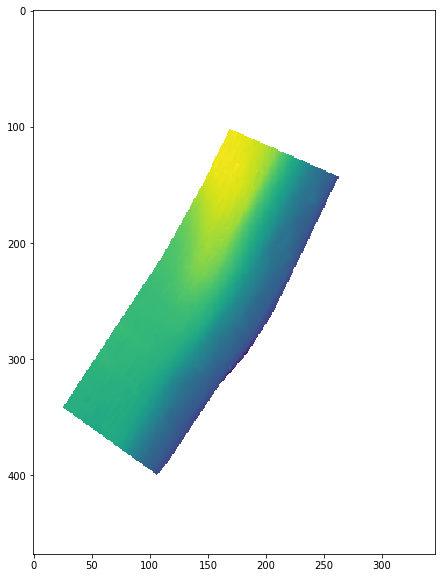

In [191]:

# # lon = x['lon']
# lat = x['lat']
# one-liner to read a single variable
# lon = loadmat('test.mat')['lon']
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x['bathy'][:,5][0][3])

# import h5py

# import numpy as np, h5py 
# f = h5py.File('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/secretharbour_survey_v3.mat','r') 
# f
# data = f.get('data/variable1') # Get a certain dataset
# data = np.array(data)

In [194]:
np.nanmin(x['bathy'][:,5][0][3])

-6.385000000032903

In [333]:
from scipy.io import loadmat
from datetime import date, timedelta
import DEAPlotting, SpatialTools
import rasterio

x = loadmat('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/secretharbour_survey_v3')
x_vals = x['bathy'][:,0][0][1]
y_vals = x['bathy'][:,0][0][2]
dates = np.array([date(1, 1, 1) + timedelta(x['bathy'][:,i][0][0].item()) for i in range(0, 15)], dtype='datetime64[s]')
data = np.stack([x['bathy'][:,i][0][3] for i in range(0, 15)])


bathy_da = xr.DataArray(data, dims=['time', 'y', 'x'], coords = {'time': dates.flatten(), 
                                                                 'x': x_vals[0,:].flatten(), 
                                                                 'y': y_vals[:,0].flatten()}, name = 'bathy')

bathy_ds = bathy_da.to_dataset()



SpatialTools.contour_extract(ds_array=bathy_ds.resample(time='Y').mean('time').bathy, z_values=0, 
                             ds_crs='epsg:32750', 
                             ds_affine=rasterio.transform.from_origin(west=np.min(x_vals), north=np.min(y_vals), xsize=5, ysize=-5),
                             output_shp='test_contour.shp')

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
    Extracting contour 2
Exporting contour shapefile to test_contour.shp


,time,geometry
0,0,"(LINESTRING (381847.4670121513 6413957.5, 3818..."
1,1,"LINESTRING (381862.0652173915 6413972.5, 38186..."
2,2,"LINESTRING (381697.0229007634 6414327.5, 38169..."
